In [2]:
import sys, os
sys.path.append(os.pardir) 
import h5py # for model file
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense
from keras.models import Sequential, load_model, Model, model_from_json
from keras import optimizers, initializers
from keras.utils import to_categorical
from keras import backend as Ke

In [3]:
# for Decision Tree
from sklearn import tree
from sklearn.metrics import accuracy_score

In [4]:
# for visualize tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image, display

In [5]:
dataset_list = ["australian", "cancer", "german", "BurstHeaderPacket", "statlog", "wine"]
#dataset_list = ["australian"]

In [ ]:
# result list and dict each data
train_result_each_data = []
test_result_each_data = []
tree_train_each_data = []
tree_result_each_data = []
tree_size_each_data = []
model_tree_each_data = {}

# run each data
for data in dataset_list:
    
    model = []
    
    # mean and stdev list each layer
    train_result_mean = []
    test_result_mean = []
    tree_train_mean = []
    tree_result_mean = []
    tree_size_mean = []
    train_result_stdev = []
    test_result_stdev = []
    tree_train_stdev = []
    tree_result_stdev = []
    
    model_tree_each_layer = []
    
    # read data file
    df = pd.read_csv("../dataset/" + str(data) + "_scaling.csv", header=None)
    
    # set parameter
    K = 10                # num of Cross-validation
    learning_rate = 0.05
    validation_data_rate = 0.1
    epochs = 100
    features_length = len(df.columns) - 1
    block_size = math.floor(len(df.index) / K)  # test data size for one validation
    num_layers = 15 # number of hidden layers 
    num_class = max(df.iloc[:, 0])
    
    print("----- " + str(data) + " -----")
    
    # run each layer
    for num_layer in range(num_layers):
        print("----- Layer_" + str(num_layer) + " -----")
        
        # result list each validation
        train_result = []
        test_result = []
        tree_train = []
        tree_result = []
        tree_size = []
        
        # run each validation
        for k in range(K):
        
            # set train and test data       
            dataset = df
            test_range = range(k * block_size, (k + 1) * block_size) # e.g. iris 0~14, 15~29 ...
            test = dataset[test_range[0]:test_range[-1] + 1]
            dataset = dataset.drop(test_range)
            train = dataset
            train_X = train.iloc[:, 1:] / 2.0
            train_Y = train.iloc[:, 0] - 1   # class 1, 2, 3 -> class 0, 1, 2
            test_X = test.iloc[:, 1:] / 2.0
            test_Y = test.iloc[:, 0] - 1

            train_X = np.array(train_X)
            train_Y = np.array(train_Y)
            test_X = np.array(test_X)
            test_Y = np.array(test_Y)

            # each layer name
            hidden_layer = str(num_layer) + "_hidden"
            
            # set name for model file
            model_dir = "./model/"
            model_dir_each_data = "./model/" + str(data) + "/"
            model_name = str(model_dir) + str(data) + "/" + str(data) +  "_L-" \
                            + str(num_layer) + "_K-" + str(k) + "_1000.h5"
            
            if not os.path.exists(model_name):
                    print("-----k = " + str(k) + "-----")
                    if num_layer == 0:
                            # organization model
                            model.append(Sequential())
                            model[k].add(Dense(features_length, input_dim=features_length, \
                                            activation="tanh", \
                                            kernel_initializer=initializers.RandomUniform(-1,1, seed=0),\
                                            bias_initializer="ones",name=hidden_layer))
                            model[k].add(Dense(num_class, activation="softmax",name="output_layer", \
                                            kernel_initializer=initializers.RandomUniform(-1,1, seed=0),\
                                            bias_initializer="ones"))

                            sgd = optimizers.SGD(lr=learning_rate)
                            model[k].compile(optimizer=sgd, loss="sparse_categorical_crossentropy", \
                                      metrics=["accuracy"])
                            model[k].summary()

                    else:
                            # adding hidden layer
                            # at first, remove output layer
                            model[k].pop()

                            # next, add new hidden layer
                            model[k].add(Dense(features_length, activation="tanh", \
                                            kernel_initializer=initializers.RandomUniform(-1,1, seed=0),\
                                            bias_initializer="ones",name=hidden_layer))

                            # fix previous weights and bias
                            for i in range(len(model[k].layers) - 1):
                                model[k].layers[i].trainable = False

                            # finally, add output layer again
                            model[k].add(Dense(num_class, activation="softmax",name="output_layer", \
                                            kernel_initializer=initializers.RandomUniform(-1,1, seed=0),\
                                            bias_initializer="ones"))

                            sgd = optimizers.SGD(lr=learning_rate)
                            model[k].compile(optimizer=sgd, loss="sparse_categorical_crossentropy", \
                                      metrics=["accuracy"])
                            model[k].summary()

                    
                    # train and test
                    history = model[k].fit(train_X, train_Y, epochs=epochs, validation_split=validation_data_rate,\
                                        batch_size=1, verbose=0)
                    res_train = model[k].evaluate(train_X, train_Y, batch_size=1, verbose=0)
                    res_test = model[k].evaluate(test_X, test_Y, batch_size=1, verbose=0)

                    train_result.append(res_train[1])
                    test_result.append(res_test[1]) # res = [loss, acc]
                

            else:
                    print("-----k = " + str(k) + " loaded model-----")
                    # if model exist, load it
                    model1 = load_model(model_name)
                    model.append(model1)

                    # test
                    res_train = model[k].evaluate(train_X, train_Y, batch_size=1, verbose=0)
                    res_test = model[k].evaluate(test_X, test_Y, batch_size=1, verbose=0)

                    train_result.append(res_train[1])
                    test_result.append(res_test[1])
            
            # extraction hidden layer output
            intermediate_layer_model = Model(inputs=model[k].input, \
                                                  outputs=model[k].get_layer(hidden_layer).output)
            intermediate_train_output = intermediate_layer_model.predict(train_X, batch_size=1)
            intermediate_test_output = intermediate_layer_model.predict(test_X, batch_size=1)

            # make Decision Tree from hidden layer output
            clf = tree.DecisionTreeClassifier(random_state=0, max_features=features_length, \
                                              presort=True)
            clf = clf.fit(intermediate_train_output, train_Y)
            predict_tree_train = clf.predict(intermediate_train_output)
            predict_tree_test = clf.predict(intermediate_test_output)
            acc_tree_train = accuracy_score(train_Y, predict_tree_train)
            acc_tree_test = accuracy_score(test_Y, predict_tree_test)
            tree_train.append(acc_tree_train)
            tree_result.append(acc_tree_test)
            
            # extraction num of tree node
            node = clf.tree_.feature
            node_num = len(node)
            tree_size.append(node_num)
            
            # sava model into model directory
            os.makedirs(model_dir, exist_ok=True)
            os.makedirs(model_dir_each_data, exist_ok=True)
            #model[k].save(model_name)
            

        print("NN_acc(train) = " + str(np.round(np.mean(train_result), 3)))
        train_result_mean.append(np.mean(train_result))
        print("NN_stdev(train) = " + str(np.round(np.std(train_result), 3)))
        train_result_stdev.append(np.std(train_result))
        print("NN_acc(test) = " + str(np.round(np.mean(test_result), 3)))
        test_result_mean.append(np.mean(test_result))
        print("NN_stdev(test) = " + str(np.round(np.std(test_result), 3)))
        test_result_stdev.append(np.std(test_result))
        
        print("tree_acc(train) = " + str(np.round(np.mean(tree_train), 3)))
        tree_train_mean.append(np.mean(tree_train))
        print("tree_stdev(train) = " + str(np.round(np.std(tree_train), 3)))
        tree_train_stdev.append(np.std(tree_train))
        print("tree_acc(test) = " + str(np.round(np.mean(tree_result), 3)))
        tree_result_mean.append(np.mean(tree_result))
        print("tree_stdev(test) = " + str(np.round(np.std(tree_result), 3)))
        tree_result_stdev.append(np.std(tree_result))
        print("tree_size = " + str(np.round(np.mean(tree_size), 3)))
        tree_size_mean.append(np.mean(tree_size))
        model_tree_each_layer.append(clf)
    
    train_result_each_data.append(train_result_mean)
    train_result_each_data.append(train_result_stdev)
    test_result_each_data.append(test_result_mean)
    test_result_each_data.append(test_result_stdev)
    
    tree_train_each_data.append(tree_train_mean)
    tree_train_each_data.append(tree_train_stdev)
    tree_result_each_data.append(tree_result_mean)
    tree_result_each_data.append(tree_result_stdev)
    tree_size_each_data.append(tree_size_mean)
    model_tree_each_data[data] = model_tree_each_layer


----- australian -----
----- Layer_0 -----
-----k = 0-----
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
0_hidden (Dense)             (None, 14)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 30        
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________
-----k = 1-----
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
0_hidden (Dense)             (None, 14)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 30        
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________
-----

train_NN


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
australian,0.900,0.924,0.929,0.946,0.951,0.954,0.958,0.961,0.964,0.962,0.965,0.965,0.966,0.964,0.967
australian_stdev,0.015,0.008,0.012,0.005,0.007,0.006,0.007,0.009,0.009,0.009,0.006,0.006,0.006,0.007,0.005
cancer,0.986,0.989,0.994,0.994,0.994,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995
cancer_stdev,0.005,0.006,0.004,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
german,0.981,0.982,0.983,0.982,0.982,0.983,0.982,0.982,0.982,0.983,0.982,0.982,0.983,0.983,0.982
german_stdev,0.003,0.002,0.002,0.001,0.002,0.002,0.002,0.003,0.002,0.003,0.002,0.003,0.003,0.003,0.002
BurstHeaderPacket,0.937,0.973,0.989,0.994,0.999,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
BurstHeaderPacket_stdev,0.016,0.011,0.005,0.005,0.003,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
statlog,0.970,0.991,0.994,0.994,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995,0.995
statlog_stdev,0.007,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.001,0.001,0.001,0.001


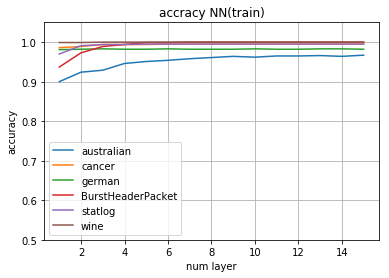



test_NN


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
australian,0.839,0.813,0.799,0.803,0.801,0.794,0.791,0.791,0.791,0.787,0.788,0.788,0.790,0.788,0.787
australian_stdev,0.049,0.050,0.046,0.041,0.044,0.053,0.052,0.046,0.046,0.050,0.052,0.049,0.046,0.051,0.049
cancer,0.960,0.957,0.959,0.957,0.957,0.957,0.957,0.956,0.956,0.953,0.956,0.956,0.954,0.956,0.956
cancer_stdev,0.029,0.031,0.035,0.034,0.039,0.039,0.039,0.043,0.043,0.046,0.043,0.043,0.042,0.043,0.043
german,0.853,0.847,0.849,0.852,0.852,0.852,0.849,0.847,0.848,0.847,0.850,0.851,0.855,0.853,0.852
german_stdev,0.026,0.032,0.026,0.029,0.030,0.026,0.029,0.026,0.026,0.026,0.023,0.025,0.027,0.030,0.030
BurstHeaderPacket,0.927,0.972,0.987,0.993,0.998,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
BurstHeaderPacket_stdev,0.028,0.026,0.014,0.008,0.006,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
statlog,0.963,0.971,0.973,0.973,0.974,0.974,0.973,0.971,0.970,0.971,0.970,0.971,0.970,0.970,0.970
statlog_stdev,0.015,0.013,0.014,0.014,0.013,0.014,0.013,0.014,0.014,0.013,0.013,0.013,0.013,0.014,0.014


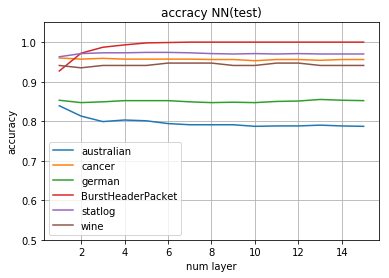



train_tree


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
australian,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,0.999
australian_stdev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.001,0.001
cancer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,0.999,0.999,0.999
cancer_stdev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.001,0.001,0.002
german,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000
german_stdev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
BurstHeaderPacket,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000
BurstHeaderPacket_stdev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
statlog,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000
statlog_stdev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000


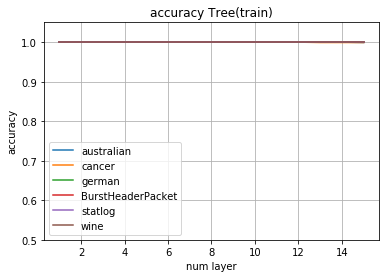



test_tree


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
australian,0.781,0.801,0.790,0.781,0.788,0.783,0.786,0.777,0.790,0.777,0.780,0.780,0.772,0.775,0.777
australian_stdev,0.079,0.063,0.064,0.055,0.053,0.069,0.051,0.061,0.041,0.039,0.057,0.048,0.049,0.038,0.048
cancer,0.953,0.947,0.957,0.957,0.951,0.956,0.951,0.953,0.956,0.954,0.954,0.954,0.956,0.956,0.953
cancer_stdev,0.039,0.041,0.033,0.037,0.044,0.041,0.043,0.041,0.034,0.037,0.040,0.040,0.038,0.038,0.041
german,0.791,0.830,0.830,0.823,0.835,0.842,0.836,0.836,0.834,0.825,0.829,0.837,0.843,0.837,0.847
german_stdev,0.045,0.036,0.030,0.036,0.023,0.021,0.021,0.024,0.032,0.022,0.026,0.026,0.024,0.032,0.033
BurstHeaderPacket,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
BurstHeaderPacket_stdev,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
statlog,0.955,0.964,0.967,0.967,0.969,0.970,0.967,0.967,0.970,0.968,0.969,0.966,0.969,0.968,0.968
statlog_stdev,0.017,0.014,0.014,0.017,0.015,0.013,0.012,0.013,0.012,0.016,0.015,0.013,0.013,0.013,0.015


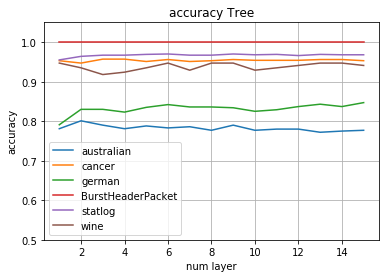



subtraction


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
australian,0.058,0.012,0.009,0.022,0.013,0.011,0.005,0.014,0.001,0.010,0.008,0.008,0.018,0.013,0.010
australian_stdev,-0.030,-0.013,-0.018,-0.014,-0.009,-0.016,0.001,-0.015,0.005,0.011,-0.005,0.001,-0.003,0.013,0.001
cancer,0.007,0.010,0.002,0.000,0.006,0.001,0.006,0.003,0.000,-0.001,0.002,0.002,-0.002,0.000,0.003
cancer_stdev,-0.010,-0.010,0.002,-0.003,-0.005,-0.002,-0.004,0.002,0.009,0.009,0.003,0.003,0.004,0.005,0.002
german,0.062,0.017,0.019,0.029,0.017,0.010,0.013,0.011,0.014,0.022,0.021,0.014,0.012,0.016,0.005
german_stdev,-0.019,-0.004,-0.004,-0.007,0.007,0.005,0.008,0.002,-0.006,0.004,-0.003,-0.001,0.003,-0.002,-0.003
BurstHeaderPacket,-0.073,-0.028,-0.013,-0.007,-0.002,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BurstHeaderPacket_stdev,0.028,0.026,0.014,0.008,0.006,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
statlog,0.008,0.007,0.006,0.006,0.005,0.004,0.006,0.004,0.000,0.003,0.001,0.005,0.001,0.002,0.002
statlog_stdev,-0.002,-0.001,0.000,-0.003,-0.002,0.001,0.001,0.001,0.002,-0.003,-0.002,0.000,0.000,0.001,-0.001


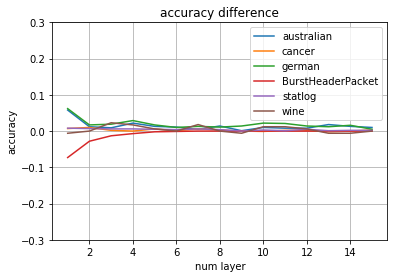



tree_size


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
australian,138.4,106.6,86.8,78.8,71.2,71.2,68.4,67.0,61.6,63.4,64.4,63.2,65.0,64.8,66.4
cancer,29.6,16.4,12.8,11.6,10.8,10.4,10.4,11.0,11.4,11.4,12.2,11.8,11.4,11.4,11.6
german,169.8,52.6,46.2,44.4,48.4,45.6,47.8,48.8,48.4,49.2,51.4,53.6,52.4,56.2,55.4
BurstHeaderPacket,65.4,41.8,20.8,15.4,10.4,8.0,7.2,7.4,7.0,7.0,7.0,7.0,7.0,7.0,7.0
statlog,132.8,86.0,57.4,44.8,39.6,38.4,36.4,35.8,36.2,37.2,36.8,34.6,38.4,38.0,38.0
wine,6.2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


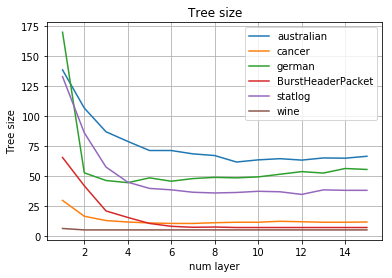

In [7]:

dataset_name = ["australian", "australian_stdev", "cancer", "cancer_stdev", "german", "german_stdev", \
                "BurstHeaderPacket", "BurstHeaderPacket_stdev", \
                "statlog", "statlog_stdev", "wine", "wine_stdev"]

#dataset_name = ["australian", "australian_stdev"]


layer_num_list = np.arange(num_layers) + 1
if not os.path.exists("./result/"):
    os.makedirs("./result/", exist_ok=True)
# set file name
train_csv = "./result/train.csv"
result_csv = "./result/test.csv"
train_tree_csv = "./result/tree_train.csv"
result_tree_csv = "./result/tree_test.csv"
result_sub_csv = "./result/sub.csv"
size_csv = "./result/tree_size.csv"

# make dataframe and file
df_train= pd.DataFrame(np.round(train_result_each_data, 3), index=dataset_name, \
                       columns=layer_num_list)
df_train.to_csv(train_csv)
print("train_NN")
display(df_train)

# make result graph
#plt.figure(figsize=(15, 10))
for i, name in enumerate(dataset_name):
    if(i%2 == 0):
        plt.plot(layer_num_list, df_train.iloc[i], label=name)
plt.legend()
plt.ylim([0.5, 1.05])
plt.grid(True)
plt.title("accracy NN(train)")
plt.xlabel("num layer")
plt.ylabel("accuracy")
plt.savefig("acc_NN_train(original).png")
plt.show()

# make dataframe and file
df_test= pd.DataFrame(np.round(test_result_each_data, 3), index=dataset_name, \
                       columns=layer_num_list)
df_test.to_csv(result_csv)
print("\n\ntest_NN")
display(df_test)

# make result graph
#plt.figure(figsize=(15, 10))
for i, name in enumerate(dataset_name):
    if(i%2 == 0):
        plt.plot(layer_num_list, df_test.iloc[i], label=name)
plt.legend()
plt.ylim([0.5, 1.05])
plt.grid(True)
plt.title("accracy NN(test)")
plt.xlabel("num layer")
plt.ylabel("accuracy")
plt.savefig("acc_NN_test(original).png")
plt.show()


df_tree_train = pd.DataFrame(np.round(tree_train_each_data, 3), index=dataset_name, \
                       columns=layer_num_list)
df_tree_train.to_csv(train_tree_csv)
print("\n\ntrain_tree")
display(df_tree_train)

#plt.figure(figsize=(15, 10))
for i, name in enumerate(dataset_name):
    if(i%2 == 0):
        plt.plot(layer_num_list, df_tree_train.iloc[i], label=name)
plt.legend()
plt.ylim([0.5, 1.05])
plt.grid(True)
plt.title("accuracy Tree(train)")
plt.xlabel("num layer")
plt.ylabel("accuracy")
plt.savefig("acc_Tree_train(original).png")
plt.show()


df_tree_test = pd.DataFrame(np.round(tree_result_each_data, 3), index=dataset_name, \
                       columns=layer_num_list)
df_tree_test.to_csv(result_tree_csv)
print("\n\ntest_tree")
display(df_tree_test)

#plt.figure(figsize=(15, 10))
for i, name in enumerate(dataset_name):
    if(i%2 == 0):
        plt.plot(layer_num_list, df_tree_test.iloc[i], label=name)
plt.legend()
plt.ylim([0.5, 1.05])
plt.grid(True)
plt.title("accuracy Tree")
plt.xlabel("num layer")
plt.ylabel("accuracy")
plt.savefig("acc_Tree_test(original).png")
plt.show()


df_sub = np.round((df_test - df_tree_test), 3)
df_sub.to_csv(result_sub_csv)
print("\n\nsubtraction")
display(df_sub)

#plt.figure(figsize=(15, 10))
for i, name in enumerate(dataset_name):
    if(i%2 == 0):
        plt.plot(layer_num_list, df_sub.iloc[i], label=name)
plt.legend()
plt.ylim([-0.3, 0.3])
plt.grid(True)
plt.title("accuracy difference")
plt.xlabel("num layer")
plt.ylabel("accuracy")
plt.savefig("acc_sub(original).png")
plt.show()


df_size = pd.DataFrame(np.round(tree_size_each_data, 3), index=dataset_list, \
                       columns=layer_num_list)
df_size.to_csv(size_csv)
print("\n\ntree_size")
display(df_size)

#plt.figure(figsize=(15, 10))
for i, name in enumerate(dataset_list):
    plt.plot(layer_num_list, df_size.iloc[i], label=name)
plt.legend()
plt.grid(True)
plt.title("Tree size")
plt.xlabel("num layer")
plt.ylabel("Tree size")
plt.savefig("size_Tree(original).png")
plt.show()


In [35]:
# visualizing Tree (using pydotplus)
os.makedirs("./graph", exist_ok=True)
for data in dataset_list:
    dir_data = "./graph/" + str(data)
    os.makedirs(dir_data, exist_ok=True)

    for i in range(num_layers):
        name_graph = str(dir_data) + "/graph_" + str(data) + "_L_" + str(i) + ".pdf"
        dot_data = StringIO()
        tree.export_graphviz(model_tree_each_data[data][i], out_file=dot_data)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

        Image(graph.create_png())

        # make tree pdf file
        graph.write_pdf(name_graph)

In [13]:
tree_raw_result_each_data = []
tree_raw_size_each_data = []
model_raw = {}

for data in dataset_list:
    tree_raw_result_mean = []
    tree_raw_size_mean = []
    df = pd.read_csv("../dataset/" + str(data) + "_scaling.csv", header=None)
    
    K = 10
    features_length = len(df.columns) - 1
    block_size = math.floor(len(df.index) / K)  # test data size for one validation
    
    print("----- " + str(data) + " -----")
    
    tree_raw_result = []
    tree_raw_size = []
    for k in range(K):
        
            dataset = df
            test_range = range(k * block_size, (k + 1) * block_size)
            test = dataset[test_range[0]:test_range[-1] + 1]
            dataset = dataset.drop(test_range)
            train = dataset
            train_X = train.iloc[:, 1:] / 2.0
            train_Y = train.iloc[:, 0] - 1
            test_X = test.iloc[:, 1:] / 2.0
            test_Y = test.iloc[:, 0] - 1

            train_X = np.array(train_X)
            train_Y = np.array(train_Y)
            test_X = np.array(test_X)
            test_Y = np.array(test_Y)

            hidden_layer = str(num_layer) + "_hidden"
            
            clf_raw = tree.DecisionTreeClassifier(random_state=0, max_features=features_length)
            clf_raw = clf_raw.fit(train_X, train_Y)
            predict_tree = clf_raw.predict(test_X)
            acc_tree = accuracy_score(predict_tree, test_Y)
            #print(acc_tree)
            tree_raw_result.append(acc_tree)
            node = clf_raw.tree_.feature
            node_num = len(node)
            tree_raw_size.append(node_num)

            
    print("tree_raw_acc = " + str(np.round(np.mean(tree_raw_result), 3)))
    tree_raw_result_mean.append(np.mean(tree_raw_result))
    print("tree_raw_size = " + str(np.round(np.mean(tree_raw_size), 3)))
    tree_raw_size_mean.append(np.mean(tree_raw_size))
    
    tree_raw_result_each_data.append(tree_raw_result_mean)
    tree_raw_size_each_data.append(tree_raw_size_mean)
    
    model_raw[data] = clf_raw

----- australian -----
tree_raw_acc = 0.807
tree_raw_size = 156.8
----- cancer -----
tree_raw_acc = 0.946
tree_raw_size = 57.8
----- german -----
tree_raw_acc = 0.815
tree_raw_size = 225.4
----- BurstHeaderPacket -----
tree_raw_acc = 1.0
tree_raw_size = 63.0
----- statlog -----
tree_raw_acc = 0.964
tree_raw_size = 139.2
----- wine -----
tree_raw_acc = 0.841
tree_raw_size = 17.6


In [16]:
os.makedirs("./result_raw", exist_ok=True)

df_tree_raw = pd.DataFrame(np.round(tree_raw_result_each_data, 3), index=dataset_list)
df_tree_raw.to_csv("./result_raw/tree_raw_result.csv")
print("\n\ntest_raw_tree")
print(df_tree_raw)
df_size_raw = pd.DataFrame(np.round(tree_raw_size_each_data, 3), index=dataset_list)
df_size_raw.to_csv("./result_raw/tree_raw_size.csv")
print("\n\ntree_raw_size")
print(df_size_raw)



test_raw_tree
                       0
australian         0.807
cancer             0.946
german             0.815
BurstHeaderPacket  1.000
statlog            0.964
wine               0.841


tree_raw_size
                       0
australian         156.8
cancer              57.8
german             225.4
BurstHeaderPacket   63.0
statlog            139.2
wine                17.6


In [15]:
# visualizing Tree (using pydotplus)
os.makedirs("./graph_raw", exist_ok=True)
for data in dataset_list:
    dir_data = "./graph_raw/" + str(data)
    os.makedirs(dir_data, exist_ok=True)

    
    name_graph = str(dir_data) + "/graph_" + str(data) + "_L_" + str(i) + ".pdf"
    dot_data = StringIO()
    tree.export_graphviz(model_raw[data], out_file=dot_data)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    Image(graph.create_png())

    # make tree pdf file
    graph.write_pdf(name_graph)